In [1]:
def gauss_seidel(A, b, x0, max_iterations=50):
    n = len(A)
    x = x0.copy()

    for _ in range(max_iterations):
        for i in range(n):
            sum_ax = sum(A[i][j] * x[j] for j in range(n) if j != i)
            x[i] = (b[i] - sum_ax) / A[i][i]
    return x


In [2]:
#compute Error
def cal_error(A, b, x):
    sum_err = 0
    for i in range (16):
        sum_err = sum_err + (sum(A[i][j] * x[j] for j in range(16))-b[i])**2
    return sum_err

In [3]:
def pipelined_gauss_seidel(A, b, x0, max_iterations=100):
    n = len(A)
    x = x0.copy()
    prev = []
    for _  in range(max_iterations):
        for i in range(0, n, 4):
            if len(prev) == 4:
                #x[(i-1)%16] = prev.pop(0)
                x[i+3] = prev.pop(0)
            tmp = 1/20 * (b[i] + 13*((x[i-1] if i-1 >= 0 else 0) + (x[i+1] if i+1 < n else 0)) - 6 * ((x[i-2] if i-2 >= 0 else 0) + (x[i+2] if i+2 < n else 0)) + (x[i-3] if i-3 >= 0 else 0) + (x[i+3] if i+3 < n else 0)) 
            prev.append(tmp)
            #print(len(prev))
        for i in range(1, n, 4):
            x[i-1] = prev.pop(0)
            tmp = 1/20 * (b[i] + 13*((x[i-1] if i-1 >= 0 else 0) + (x[i+1] if i+1 < n else 0)) - 6 * ((x[i-2] if i-2 >= 0 else 0) + (x[i+2] if i+2 < n else 0)) + (x[i-3] if i-3 >= 0 else 0) + (x[i+3] if i+3 < n else 0)) 
            prev.append(tmp)
        for i in range(2, n, 4):
            x[i-1] = prev.pop(0)
            tmp = 1/20 * (b[i] + 13*((x[i-1] if i-1 >= 0 else 0) + (x[i+1] if i+1 < n else 0)) - 6 * ((x[i-2] if i-2 >= 0 else 0) + (x[i+2] if i+2 < n else 0)) + (x[i-3] if i-3 >= 0 else 0) + (x[i+3] if i+3 < n else 0)) 
            prev.append(tmp)
        for i in range(3, n, 4):
            x[i-1] = prev.pop(0)
            #if i == 11:
            #    print(x)
            tmp = 1/20 * (b[i] + 13*((x[i-1] if i-1 >= 0 else 0) + (x[i+1] if i+1 < n else 0)) - 6 * ((x[i-2] if i-2 >= 0 else 0) + (x[i+2] if i+2 < n else 0)) + (x[i-3] if i-3 >= 0 else 0) + (x[i+3] if i+3 < n else 0)) 
            prev.append(tmp)
    
    #if len(prev) > 0:
    #    for i in range(3, n, 4):
    #        x[i-1] = prev.pop(0)
    #return x
    for i in range(3, n, 4):
        if len(prev)>0:
            #print(len(prev))
            x[i] = prev.pop(0)
    return x

In [4]:
def pipelined_dual_core_gauss_seidel(A, b, x0, max_iterations=100):
    n = len(A)
    x = x0.copy()
    pipreg1 = []
    pipreg2 = []
    for _  in range(max_iterations):
        for i in range(0, n, 4):

            if len(pipreg1) == 4:
                x[i+3] = pipreg1.pop(0)

            j = (i+8)%16
            if len(pipreg2) == 4:
                x[j+3] = pipreg2.pop(0)

            #CORE 1
            tmp1 = 1/20 * (b[i] + 13*((x[i-1] if i-1 >= 0 else 0) + (x[i+1] if i+1 < n else 0)) - 6 * ((x[i-2] if i-2 >= 0 else 0) + (x[i+2] if i+2 < n else 0)) + (x[i-3] if i-3 >= 0 else 0) + (x[i+3] if i+3 < n else 0)) 
            pipreg1.append(tmp1)

            #CORE 2

            tmp2 = 1/20 * (b[j] + 13*((x[j-1] if j-1 >= 0 else 0) + (x[j+1] if j+1 < n else 0)) - 6 * ((x[j-2] if j-2 >= 0 else 0) + (x[j+2] if j+2 < n else 0)) + (x[j-3] if j-3 >= 0 else 0) + (x[j+3] if j+3 < n else 0)) 
            pipreg2.append(tmp2)

        for i in range(1, n, 4):
            
            x[i-1] = pipreg1.pop(0)

            j = (i+8)%16
            x[j-1] = pipreg2.pop(0)

            #CORE 1
            tmp1 = 1/20 * (b[i] + 13*((x[i-1] if i-1 >= 0 else 0) + (x[i+1] if i+1 < n else 0)) - 6 * ((x[i-2] if i-2 >= 0 else 0) + (x[i+2] if i+2 < n else 0)) + (x[i-3] if i-3 >= 0 else 0) + (x[i+3] if i+3 < n else 0)) 
            pipreg1.append(tmp1)

            #CORE 2

            tmp2 = 1/20 * (b[j] + 13*((x[j-1] if j-1 >= 0 else 0) + (x[j+1] if j+1 < n else 0)) - 6 * ((x[j-2] if j-2 >= 0 else 0) + (x[j+2] if j+2 < n else 0)) + (x[j-3] if j-3 >= 0 else 0) + (x[j+3] if j+3 < n else 0)) 
            pipreg2.append(tmp2)
        for i in range(2, n, 4):
            x[i-1] = pipreg1.pop(0)

            j = (i+8)%16
            x[j-1] = pipreg2.pop(0)
            
            #CORE 1
            tmp1 = 1/20 * (b[i] + 13*((x[i-1] if i-1 >= 0 else 0) + (x[i+1] if i+1 < n else 0)) - 6 * ((x[i-2] if i-2 >= 0 else 0) + (x[i+2] if i+2 < n else 0)) + (x[i-3] if i-3 >= 0 else 0) + (x[i+3] if i+3 < n else 0)) 
            pipreg1.append(tmp1)

            #CORE 2

            tmp2 = 1/20 * (b[j] + 13*((x[j-1] if j-1 >= 0 else 0) + (x[j+1] if j+1 < n else 0)) - 6 * ((x[j-2] if j-2 >= 0 else 0) + (x[j+2] if j+2 < n else 0)) + (x[j-3] if j-3 >= 0 else 0) + (x[j+3] if j+3 < n else 0)) 
            pipreg2.append(tmp2)
        for i in range(3, n, 4):
            x[i-1] = pipreg1.pop(0)

            j = (i+8)%16
            x[j-1] = pipreg2.pop(0)
            
            #CORE 1
            tmp1 = 1/20 * (b[i] + 13*((x[i-1] if i-1 >= 0 else 0) + (x[i+1] if i+1 < n else 0)) - 6 * ((x[i-2] if i-2 >= 0 else 0) + (x[i+2] if i+2 < n else 0)) + (x[i-3] if i-3 >= 0 else 0) + (x[i+3] if i+3 < n else 0)) 
            pipreg1.append(tmp1)

            #CORE 2

            tmp2 = 1/20 * (b[j] + 13*((x[j-1] if j-1 >= 0 else 0) + (x[j+1] if j+1 < n else 0)) - 6 * ((x[j-2] if j-2 >= 0 else 0) + (x[j+2] if j+2 < n else 0)) + (x[j-3] if j-3 >= 0 else 0) + (x[j+3] if j+3 < n else 0)) 
            pipreg2.append(tmp2)
    

    for i in range(3, n, 4):
        j = (i+8)%16
        if len(pipreg1)>0:
            #print(len(prev))
            x[i] = pipreg1.pop(0)
            x[j] = pipreg2.pop(0)
            
    return x

In [5]:
A = [
    [20, -13, 6, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    [-13, 20, -13, 6, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [6, -13, 20, -13, 6, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [-1, 6, -13, 20, -13, 6, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, -1, 6, -13, 20, -13, 6, -1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, -1, 6, -13, 20, -13, 6, -1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, -1, 6, -13, 20, -13, 6, -1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, -1, 6, -13, 20, -13, 6, -1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, -1, 6, -13, 20, -13, 6, -1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, -1, 6, -13, 20, -13, 6, -1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, -1, 6, -13, 20, -13, 6, -1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, -1, 6, -13, 20, -13, 6, -1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 6, -13, 20, -13, 6, -1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 6, -13, 20, -13, 6],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 6, -13, 20, -13],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 6, -13, 20]
    ]
b = [7, 6, 5, 4, 5, 6, 7, 8, 9, 8, 7, 6, 5, 4, 3, 2]
x0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

result = gauss_seidel(A, b, x0)
print(result)
print(cal_error(A, b, result))


[1.0468154694133478, 1.666200755994911, 1.4639599533046845, 1.0594622866832415, 1.0407113225051992, 1.3707400779550962, 1.803345414782936, 2.159224086975314, 2.2902221485005816, 2.1035150451155475, 1.7729249871624657, 1.4757167508545828, 1.2556864463444035, 1.0447127285100068, 0.7415307366355572, 0.33136548257733034]
5.174479389550875e-11


In [6]:
A = [
    [20, -13, 6, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    [-13, 20, -13, 6, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [6, -13, 20, -13, 6, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [-1, 6, -13, 20, -13, 6, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, -1, 6, -13, 20, -13, 6, -1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, -1, 6, -13, 20, -13, 6, -1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, -1, 6, -13, 20, -13, 6, -1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, -1, 6, -13, 20, -13, 6, -1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, -1, 6, -13, 20, -13, 6, -1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, -1, 6, -13, 20, -13, 6, -1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, -1, 6, -13, 20, -13, 6, -1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, -1, 6, -13, 20, -13, 6, -1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 6, -13, 20, -13, 6, -1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 6, -13, 20, -13, 6],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 6, -13, 20, -13],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 6, -13, 20]
    ]
b1 = [248, -682, 24710, -9624, -3313, 30377, -29996, 30995, -20368, 10952, 5665, 11476, -9108, 7882, 20391, -31505]
b2 = [20625, 26594, -24445, 27091, 8674, -26375, -14516, 3072, 29983, 30466, -22438, 30840, 29960, -958, 19679, -23469]
b3 = [-6435, -27789, -17045, -24686, -20715, -17042, -5422, -29513, 26392, 29149, -599, -704, -10635, 26218, -8569, -25480]
b4 = [20020, 5028, -20780, -17044, 25330, -30888, -662, -21762, 31370, 13939, 31, -1895, -28860, 11926, -29987, -28085]
b5 = [22408, 21818, -15962, 7436, 5390, 2670, 24244, -15415, -11923, -24955, 28824, 9539, -1346, 9130, 2930, 9654]
     
x0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
iter = 69
result = pipelined_gauss_seidel(A, b1, x0,iter)
print("result1 = ", result)
print("error1 = ", cal_error(A, b1, result))
result = pipelined_gauss_seidel(A, b2, x0,iter)
print("result2 = ", result)
print("error2 = ", cal_error(A, b2, result))
result = pipelined_gauss_seidel(A, b3, x0,iter)
print("result3 = ", result)
print("error3 = ", cal_error(A, b3, result))
result = pipelined_gauss_seidel(A, b4, x0,iter)
print("result4 = ", result)
print("error4 = ", cal_error(A, b4, result))
result = pipelined_gauss_seidel(A, b5, x0,iter)
print("result5 = ", result)
print("error5 = ", cal_error(A, b5, result))


result1 =  [402.1120196649948, 1689.5336811175455, 2455.477433175983, 563.1671564361685, 703.0136753321776, 1745.1919059989655, 33.200224217604806, 607.1379098264495, -477.58957072398744, 869.0943874695912, 1907.5237839332347, 1524.3408803164025, 596.4154512866756, 1476.634558606526, 1011.5707964109923, -1330.898577350479]
error1 =  9.74637766910657e-09
result2 =  [2912.95645497498, 3563.4672307501096, 1975.2084610039872, 3160.3057997176547, 91.03543503346069, -5435.928785733648, -4893.780438180621, 1654.9086011060333, 7008.1872903566, 5228.684094824491, 1204.3793666262598, 3993.562962138677, 6128.925232209903, 3804.142187503278, 887.0698598633444, -1431.6509857293145]
error2 =  8.787342519250424e-08
result3 =  [-2248.262090701696, -5359.644211211392, -6168.08447027079, -5863.37399246339, -5171.62299592128, -4936.763192403436, -4695.4651192257925, -2137.3295546145264, 4742.744862252828, 6766.008352960952, 2298.866213864784, -1152.757631727477, -414.8348212939069, 1708.8548094472508, -7

In [7]:
A = [
    [20, -13, 6, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    [-13, 20, -13, 6, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [6, -13, 20, -13, 6, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [-1, 6, -13, 20, -13, 6, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, -1, 6, -13, 20, -13, 6, -1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, -1, 6, -13, 20, -13, 6, -1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, -1, 6, -13, 20, -13, 6, -1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, -1, 6, -13, 20, -13, 6, -1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, -1, 6, -13, 20, -13, 6, -1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, -1, 6, -13, 20, -13, 6, -1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, -1, 6, -13, 20, -13, 6, -1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, -1, 6, -13, 20, -13, 6, -1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 6, -13, 20, -13, 6, -1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 6, -13, 20, -13, 6],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 6, -13, 20, -13],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 6, -13, 20]
    ]
b1 = [248, -682, 24710, -9624, -3313, 30377, -29996, 30995, -20368, 10952, 5665, 11476, -9108, 7882, 20391, -31505]
b2 = [20625, 26594, -24445, 27091, 8674, -26375, -14516, 3072, 29983, 30466, -22438, 30840, 29960, -958, 19679, -23469]
b3 = [-6435, -27789, -17045, -24686, -20715, -17042, -5422, -29513, 26392, 29149, -599, -704, -10635, 26218, -8569, -25480]
b4 = [20020, 5028, -20780, -17044, 25330, -30888, -662, -21762, 31370, 13939, 31, -1895, -28860, 11926, -29987, -28085]
b5 = [22408, 21818, -15962, 7436, 5390, 2670, 24244, -15415, -11923, -24955, 28824, 9539, -1346, 9130, 2930, 9654]
     
x0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
iter = 68
result = pipelined_dual_core_gauss_seidel(A, b1, x0,iter)
print("result1 = ", result)
print("error1 = ", cal_error(A, b1, result))
result = pipelined_dual_core_gauss_seidel(A, b2, x0,iter)
print("result2 = ", result)
print("error2 = ", cal_error(A, b2, result))
result = pipelined_dual_core_gauss_seidel(A, b3, x0,iter)
print("result3 = ", result)
print("error3 = ", cal_error(A, b3, result))
result = pipelined_dual_core_gauss_seidel(A, b4, x0,iter)
print("result4 = ", result)
print("error4 = ", cal_error(A, b4, result))
result = pipelined_dual_core_gauss_seidel(A, b5, x0,iter)
print("result5 = ", result)
print("error5 = ", cal_error(A, b5, result))


result1 =  [402.1120168786915, 1689.5336714269426, 2455.4774211992085, 563.1671526191565, 703.0136838961771, 1745.1919227110077, 33.20023404513861, 607.1379061547324, -477.5895835967762, 869.0943773310967, 1907.5237836223846, 1524.3408862837368, 596.4154579832275, 1476.6345604452526, 1011.5707951110103, -1330.8985784122578]
error1 =  1.1397810677823317e-08
result2 =  [2912.9564488035876, 3563.4672355469042, 1975.20848608893, 3160.3058275024637, 91.03544786847215, -5435.928807499298, -4893.780471481989, 1654.9085845423292, 7008.187295591477, 5228.6841161015545, 1204.3793811683015, 3993.562961524346, 6128.925222789679, 3804.1421795851734, 887.0698579258387, -1431.650985084273]
error2 =  5.98815164049823e-08
result3 =  [-2248.2621078883385, -5359.644211072811, -6168.084426343462, -5863.37393399977, -5171.62295997071, -4936.763228721062, -4695.465187938819, -2137.329594585369, 4742.744867680986, 6766.008398278446, 2298.866248959475, -1152.7576299536638, -414.83484128013015, 1708.8547902187

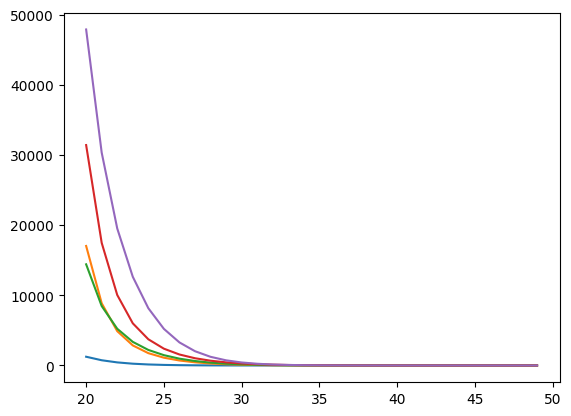

In [13]:
# Plot error rate vs iterations
import matplotlib.pyplot as plt
import numpy as np



A = [
    [20, -13, 6, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    [-13, 20, -13, 6, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [6, -13, 20, -13, 6, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [-1, 6, -13, 20, -13, 6, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, -1, 6, -13, 20, -13, 6, -1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, -1, 6, -13, 20, -13, 6, -1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, -1, 6, -13, 20, -13, 6, -1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, -1, 6, -13, 20, -13, 6, -1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, -1, 6, -13, 20, -13, 6, -1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, -1, 6, -13, 20, -13, 6, -1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, -1, 6, -13, 20, -13, 6, -1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, -1, 6, -13, 20, -13, 6, -1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 6, -13, 20, -13, 6, -1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 6, -13, 20, -13, 6],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 6, -13, 20, -13],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 6, -13, 20]
    ]
b1 = [248, -682, 24710, -9624, -3313, 30377, -29996, 30995, -20368, 10952, 5665, 11476, -9108, 7882, 20391, -31505]
b2 = [20625, 26594, -24445, 27091, 8674, -26375, -14516, 3072, 29983, 30466, -22438, 30840, 29960, -958, 19679, -23469]
b3 = [-6435, -27789, -17045, -24686, -20715, -17042, -5422, -29513, 26392, 29149, -599, -704, -10635, 26218, -8569, -25480]
b4 = [20020, 5028, -20780, -17044, 25330, -30888, -662, -21762, 31370, 13939, 31, -1895, -28860, 11926, -29987, -28085]
b5 = [22408, 21818, -15962, 7436, 5390, 2670, 24244, -15415, -11923, -24955, 28824, 9539, -1346, 9130, 2930, 9654]
b = [b1, b2, b3, b4, b5]

# one graph for each b
# use two version of gauss_seidel
# one for normal gauss_seidel
# one for dual core
# plot error rate vs iterations

for cur_b in b:
    error = []
    for i in range(20, 50):
        x0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        result = pipelined_gauss_seidel(A, cur_b, x0, i)
        error.append(cal_error(A, cur_b, result))

    plt.plot(range(20, 50), error)

plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Error rate vs Iterations')
